## Citibike Usage Seasonal Dynamic

#### Introduction:
Citibike data shows that there is a seasonality with bike ridership for subscribers. It says that there is relatively low bike usage during winter time. 

It is presumed that many subscribers follow a pattern in trip duration, such as grocery shopping or commuting. However, it is not clear that whether there is a seasonal dynamic in such usage pattern. In this research, we look into citibike data generated by subscribers in summer months (July and August, 2015) and winter months (January and Febuary, 2015), in order to compare the seasonal difference in trip duration generated by subscribers.

### Hypothesis Development:
#### H0 = μ1 - μ2 = 0
We question if there is a significant difference between the mean of trip duration in summer months and winter months by subscribers. There is no difference in the average trip duration of subscribers in summer months as compared to the winter months.

#### H1= μ1 - μ2 != 0

We will use a significance level  $\alpha=0.05$

In [1]:
from __future__ import print_function
__author__='Shalmali'

%pylab inline
import pandas as pd
import os
import sys
import numpy as np
from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit, minimize
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


In [61]:
jul = pd.read_csv("201507-citibike-tripdata.csv")
aug = pd.read_csv("201508-citibike-tripdata.csv")
summer = pd.concat([jul, aug], axis = 0)

jan = pd.read_csv("201501-citibike-tripdata.csv")
feb = pd.read_csv("201502-citibike-tripdata.csv")
winter = pd.concat([jan, feb], axis = 0)

In [62]:
len(summer)

2264720

In [63]:
len(winter)

482482

In [64]:
# Subset a dataframe with subscribers only.
summer_sub = summer[summer['usertype'] == 'Subscriber']
winter_sub = winter[winter['usertype'] == 'Subscriber']

In [65]:
summer_sub.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,732,7/1/2015 00:00:03,7/1/2015 00:12:16,489,10 Ave & W 28 St,40.750664,-74.001768,368,Carmine St & 6 Ave,40.730386,-74.002150,18669,Subscriber,1970.0,1
1,322,7/1/2015 00:00:06,7/1/2015 00:05:29,304,Broadway & Battery Pl,40.704633,-74.013617,3002,South End Ave & Liberty St,40.711512,-74.015756,14618,Subscriber,1984.0,1
2,790,7/1/2015 00:00:17,7/1/2015 00:13:28,447,8 Ave & W 52 St,40.763707,-73.985162,358,Christopher St & Greenwich St,40.732916,-74.007114,18801,Subscriber,1992.0,1


In [7]:
len(summer_sub)

1863362

In [59]:
winter_sub.head(3)

0    1346
1     363
2     346
Name: tripduration, dtype: int64

In [19]:
summer_mean = summer_sub['tripduration'].mean()
winter_mean = winter_sub['tripduration'].mean()

In [20]:
summer_sub['tripduration'].describe()

count    1.863362e+06
mean     8.112439e+02
std      5.576341e+03
min      6.000000e+01
25%      3.820000e+02
50%      6.020000e+02
75%      9.600000e+02
max      3.611666e+06
Name: tripduration, dtype: float64

In [72]:
#We suspect there are outliers in our observations, therefore we need to clean
summer_dur = summer_sub['tripduration']
summer_dur_clean = summer_dur[(np.abs(stats.zscore(summer_dur)) < 3)]

winter_dur = winter_sub['tripduration']
winter_dur_clean = winter_dur[(np.abs(stats.zscore(winter_dur)) < 3)]

In [73]:
summer_dur_clean = summer_dur_clean.to_frame()

In [74]:
winter_dur_clean = winter_dur_clean.to_frame()

In [82]:
stats.ttest_ind(summer_dur_clean, winter_dur_clean, equal_var= False)

Ttest_indResult(statistic=array([ 203.14597566]), pvalue=array([ 0.]))

In [22]:
summer_dur_clean.describe()

count    1.861956e+06
mean     7.573256e+02
std      6.167404e+02
min      6.000000e+01
25%      3.820000e+02
50%      6.010000e+02
75%      9.590000e+02
max      1.753000e+04
Name: tripduration, dtype: float64

In [23]:
winter_dur_clean.describe()

count    472979.000000
mean        606.803974
std         403.792930
min          60.000000
25%         334.000000
50%         499.000000
75%         753.000000
max        3179.000000
Name: tripduration, dtype: float64

In [31]:
fig=pl.figure(figsize(15,15))
# Create trip duration bins, in this case we use 180 seconds (3 mins) as interval for the bins.
bins = np.arange(10, 3000, 100)

# Aggregates of trip duration:
ag_summer = summer_dur_clean.groupby(pd.cut(summer_dur_clean, bins)).agg([count_nonzero])
ag_winter = winter_dur_clean.groupby(pd.cut(winter_dur_clean, bins)).agg([count_nonzero])
ag_summer[:10]

,count_nonzero
tripduration,
"(10, 110]",14182
"(110, 210]",99341
"(210, 310]",190031
"(310, 410]",226336
"(410, 510]",220619
"(510, 610]",196856
"(610, 710]",163404
"(710, 810]",133412
"(810, 910]",107553


In [32]:
ag_winter.head(3)

,count_nonzero
tripduration,
"(10, 110]",3978
"(110, 210]",32318
"(210, 310]",64461


In [33]:
ag_winter.columns = ['Winter Trip Duration']
ag_summer.columns = ['Summer Trip Duration']

In [34]:
# Then we would like to know the percentage of trips by trip duration in these two distributions:
per_sum = (ag_summer/len(summer_dur_clean))*100
per_win = (ag_winter/len(winter_dur_clean))*100

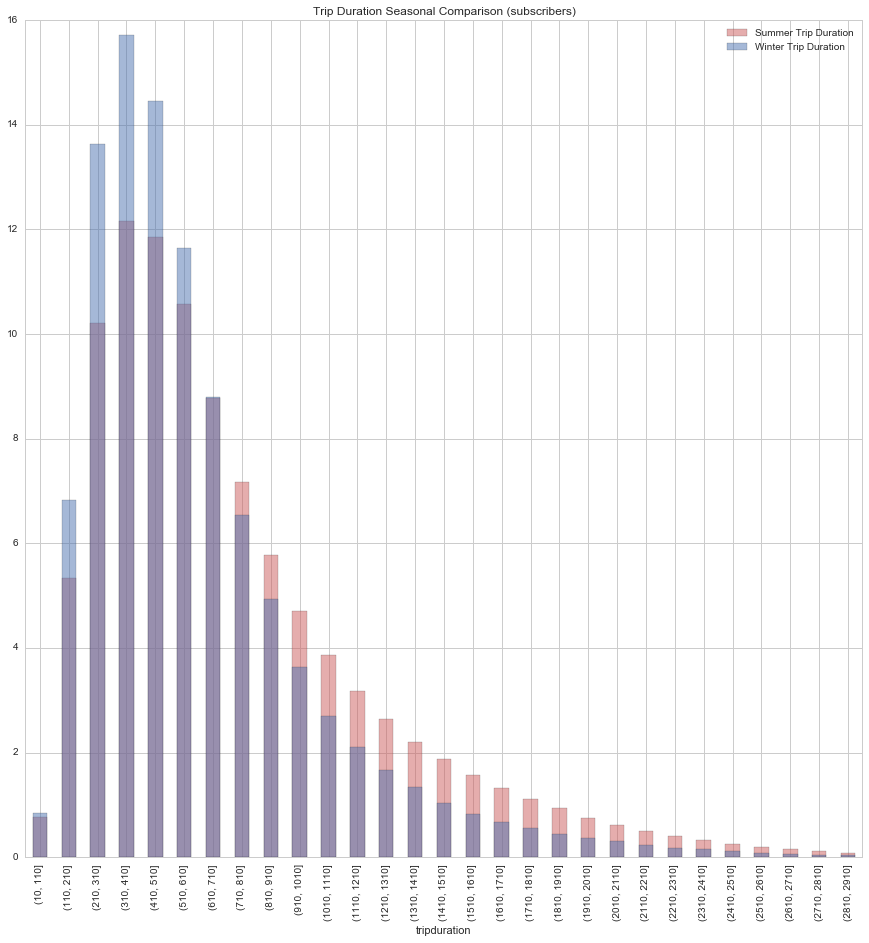

In [76]:
# Plot two trip duration distributions to compare the seasonal dynamic in trip duration.

fig = plt.figure(figsize(15,15))
ax = plt.subplot(111)
per_sum.plot(kind="bar", color = "IndianRed", alpha = 0.5, ax=ax, title = "Trip Duration Seasonal Comparison (subscribers)", label = "Summer Trip Duration")
ax = per_win.plot(kind="bar", alpha = 0.5, ax=ax)

## Figure 1: Histogram of Summer and Winter time trip duration 

### Data Inference:
Based on the plot above, we notice that more percentage of subscibers taking short trips in winter time, especially the short trips ranging from 4 mins to 7 min.

### Hypothesis Testing:
Since the summer and winter data are two separate and independent groups, and we wonder about the average trip duration, we use two sample z-test to test H0: mu1 - mu2 = 0 against Ha: mu1 - mu2 not eaqual zero. Significance level  $\alpha=0.05$

In [77]:
#In this study, we want to compare two means of trip duration in summer time and winter time. Therefore we define:
mean_s = np.mean(summer_dur_clean)
mean_w = np.mean(winter_dur_clean)
n_s = len(summer_dur_clean)
n_w = len(winter_dur_clean)
sd_s = np.std(summer_dur_clean, axis=0)
sd_w = np.std(winter_dur_clean, axis=0)
mudiff = 0

In [78]:
print (mean_s, mean_w, n_s, n_w,sd_s, sd_w )

tripduration    757.325643
dtype: float64 tripduration    606.803974
dtype: float64 1861956 472979 tripduration    616.74025
dtype: float64 tripduration    403.792503
dtype: float64


In [79]:
def twoSampZ(mean_s, mean_w, mudiff, sd_s, sd_w, n_s, n_w):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd_s**2/n_s + sd_w**2/n_w)
    z = ((mean_s - mean_w) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

In [80]:
z, p = twoSampZ(mean_s, mean_w, 0, sd_s, sd_w, n_s, n_w)
print (z, p)

tripduration    203.146
dtype: float64 [ 0.]


Based on the z-score we check the z-score table to find out: p(z > 3.4) = 0.9997 Our p value is really small which eaquals zero. Two sample z-tests are rarely used, because the estimate for the SE for difference used here is biased. Instead, statisticians use a two-sample t-test:

In [81]:
#T-test with different means, variance, and n:
stats.ttest_ind(summer_dur_clean, winter_dur_clean, equal_var = False)

Ttest_indResult(statistic=array([ 203.14597566]), pvalue=array([ 0.]))

### The p-value is zero, therefore we can reject the null hypothesis and state that there is a trip duration difference between summer time and winter time.